In [1]:
import os
os.environ["STPSF_PATH"] = "/d/ret1/Taylor/stpsf-data/" 
import webbpsf
os.environ["STPSF_PATH"] = "/d/ret1/Taylor/stpsf-data/" #TJ for some reason this only works if you do this line twice... no idea why
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.patches import Circle, Rectangle
from matplotlib.gridspec import GridSpec
from tabulate import tabulate
import pickle
import glob
import re
import sys

from photutils.aperture import CircularAperture, aperture_photometry
from spectral_cube import SpectralCube
from scipy.interpolate import interp1d
from astropy.time import Time
from astropy.coordinates import SkyCoord
from astropy.table import Table
import astropy.units as u
from astropy.wcs import WCS
from astropy.constants import c
from astropy.io import fits
from astropy.visualization import simple_norm, imshow_norm
from astropy.visualization import AsinhStretch
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization import SqrtStretch 

home_directory = "/d/ret1/Taylor/jupyter_notebooks/Research" 
os.chdir(home_directory) #TJ change working directory to be the parent directory

from Py_files.Basic_analysis import * #TJ import basic functions from custom package
from Py_files.Image_vs_spectra import *
from Py_files.Convolution_script import *
karin_IFU_files = [ 'Data_files/IFU_files/raw_IFUs/location_1/jw03435-o012_t014_nirspec_g140m-f100lp_s3d.fits',
             'Data_files/IFU_files/raw_IFUs/location_1/jw03435-o012_t014_nirspec_g235m-f170lp_s3d.fits',
             'Data_files/IFU_files/raw_IFUs/location_1/jw03435-o012_t014_nirspec_g395m-f290lp_s3d.fits',
             'Data_files/IFU_files/location_1/Arm2_Level3_ch1-shortmediumlong_s3d.fits',
             'Data_files/IFU_files/location_1/Arm2_Level3_ch2-shortmediumlong_s3d.fits',
             'Data_files/IFU_files/location_1/Arm2_Level3_ch3-shortmediumlong_s3d.fits',
             'Data_files/IFU_files/location_1/Arm2_Level3_ch4-shortmediumlong_s3d.fits']

image_files, filter_files = generate_list_of_files()

locations = [[202.5062429, 47.2143358], [202.4335225, 47.1729608], [202.4340450, 47.1732517], [202.4823742, 47.1958589]]
loc = locations[1]

ifu_file = fits.open(karin_IFU_files[0])['SCI']

image_file = fits.open(image_files[0])['SCI']

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-068 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-071
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf
/tmp/ipykernel_441478/853576724.py:3: DeprecationWarning: "
        This message is for information only and WebbPSF will continue to function as normal.
        The WebbPSF library has been moved/renamed to STPSF.
        Please see https://stpsf.readthedocs.io/en/stable/ for more information.
        WebbPSF is now an alias of STPSF and is running code from the STPSF library.
        
  import webbpsf


True
/d/ret1/Taylor/stpsf-data/


FileNotFoundError: [Errno 2] No such file or directory: 'Data_files/IFU_files/raw_IFUs/location_1/jw03435-o012_t014_nirspec_g140m-f100lp_s3d.fits'

In [6]:
def pad_to_match(psf1, psf2):
    """Pad both PSFs to have the same shape (centered)."""
    shape1 = np.array(psf1.shape)
    shape2 = np.array(psf2.shape)
    target_shape = np.maximum(shape1, shape2)

    def pad_center(psf, target_shape):
        pad_total = target_shape - np.array(psf.shape)
        pad_before = pad_total // 2
        pad_after = pad_total - pad_before
        padding = tuple((before, after) for before, after in zip(pad_before, pad_after))
        return np.pad(psf, padding, mode='constant', constant_values=0)

    return pad_center(psf1, target_shape), pad_center(psf2, target_shape)

# Compute differential kernel in Fourier space
def compute_diff_kernel(psf_native, psf_target):
    psf_native, psf_target = pad_to_match(psf_native, psf_target)

    fft_native = np.fft.fft2(np.fft.ifftshift(psf_native))
    fft_target = np.fft.fft2(np.fft.ifftshift(psf_target))

    kernel_ft = fft_target / (fft_native + 1e-16)  # prevent divide-by-zero
    differential_kernel_ft_filtered = apply_fourier_lowpass_filter(kernel_ft, sigma_fraction=0.05)
    
    kernel = np.fft.fftshift(np.fft.ifft2(differential_kernel_ft_filtered).real)
    return kernel

def test_compute_diff_kernel(psf_native, psf_target):
    psf_native, psf_target = pad_to_match(psf_native, psf_target)

    fft_native = np.fft.fft2(np.fft.ifftshift(psf_native))
    fft_target = np.fft.fft2(np.fft.ifftshift(psf_target))

    kernel_ft = fft_target / (fft_native + 1e-30)  # prevent divide-by-zero
    differential_kernel_ft_filtered = apply_fourier_lowpass_filter(kernel_ft, sigma_fraction=0.05)
    
    kernel = np.fft.fftshift(np.fft.ifft2(differential_kernel_ft_filtered).real)
    return kernel


###################################################################################################
###################################################################################################
###################################################################################################
import numpy as np
from numpy.fft import rfft2, irfft2
from scipy.ndimage import fourier_shift
from scipy.signal import fftconvolve
from photutils.psf.matching import create_matching_kernel



def _center_and_normalize(psf):
    psf = np.asarray(psf, float)
    psf = np.maximum(psf, 0)
    s = psf.sum()
    if s <= 0:
        raise ValueError("PSF has non-positive flux")
    psf /= s
    # optional: recenter to subpixel peak with FFT shift if needed
    return psf

def _hann_window(shape, frac=0.9):
    ny, nx = shape
    y = np.hanning(int(frac*ny))
    x = np.hanning(int(frac*nx))
    W = np.zeros(shape)
    y0 = (ny - y.size)//2
    x0 = (nx - x.size)//2
    W[y0:y0+y.size, x0:x0+x.size] = np.outer(y, x)
    return W


def match_psf_shapes(psf1, psf2):
    """Pad/crop two PSFs to have identical shape, centered."""
    ny1, nx1 = psf1.shape
    ny2, nx2 = psf2.shape
    ny = max(ny1, ny2)
    nx = max(nx1, nx2)
    
    def pad_to(psf, ny, nx):
        ypad = (ny - psf.shape[0]) // 2
        xpad = (nx - psf.shape[1]) // 2
        return np.pad(psf, ((ypad, ny - psf.shape[0] - ypad),
                            (xpad, nx - psf.shape[1] - xpad)),
                      mode="constant", constant_values=0)
    
    return pad_to(psf1, ny, nx), pad_to(psf2, ny, nx)


def make_differential_kernel(native_psf, target_psf, alpha=1e-4, rolloff=0.9):
    N = _center_and_normalize(native_psf)
    T = _center_and_normalize(target_psf)

    # Use rFFT for speed (real-valued PSFs)
    Nh = rfft2(N)
    Th = rfft2(T)

    # Frequency-dependent regularizer: small constant + gentle high-freq growth
    # Build |k|^2 grid in half-plane to weight α
    ny, nx = N.shape
    ky = np.fft.fftfreq(ny)[:, None]
    kx = np.fft.rfftfreq(nx)[None, :]
    k2 = (ky**2 + kx**2)
    reg = alpha * (1.0 + 10.0*k2)  # tune as needed

    Kh = (Th * Nh.conj()) / (np.abs(Nh)**2 + reg)

    # Apply tapered window in image domain by multiplying in Fourier domain with the FFT of window
    W = _hann_window(N.shape, frac=rolloff)
    Wh = rfft2(W / W.sum())  # normalize window to preserve DC

    Kh *= Wh

    K = irfft2(Kh, s=N.shape).real
    K[K < 0] = 0.0           # optional: clip tiny negatives
    s = K.sum()
    if s > 0: K /= s
    return K




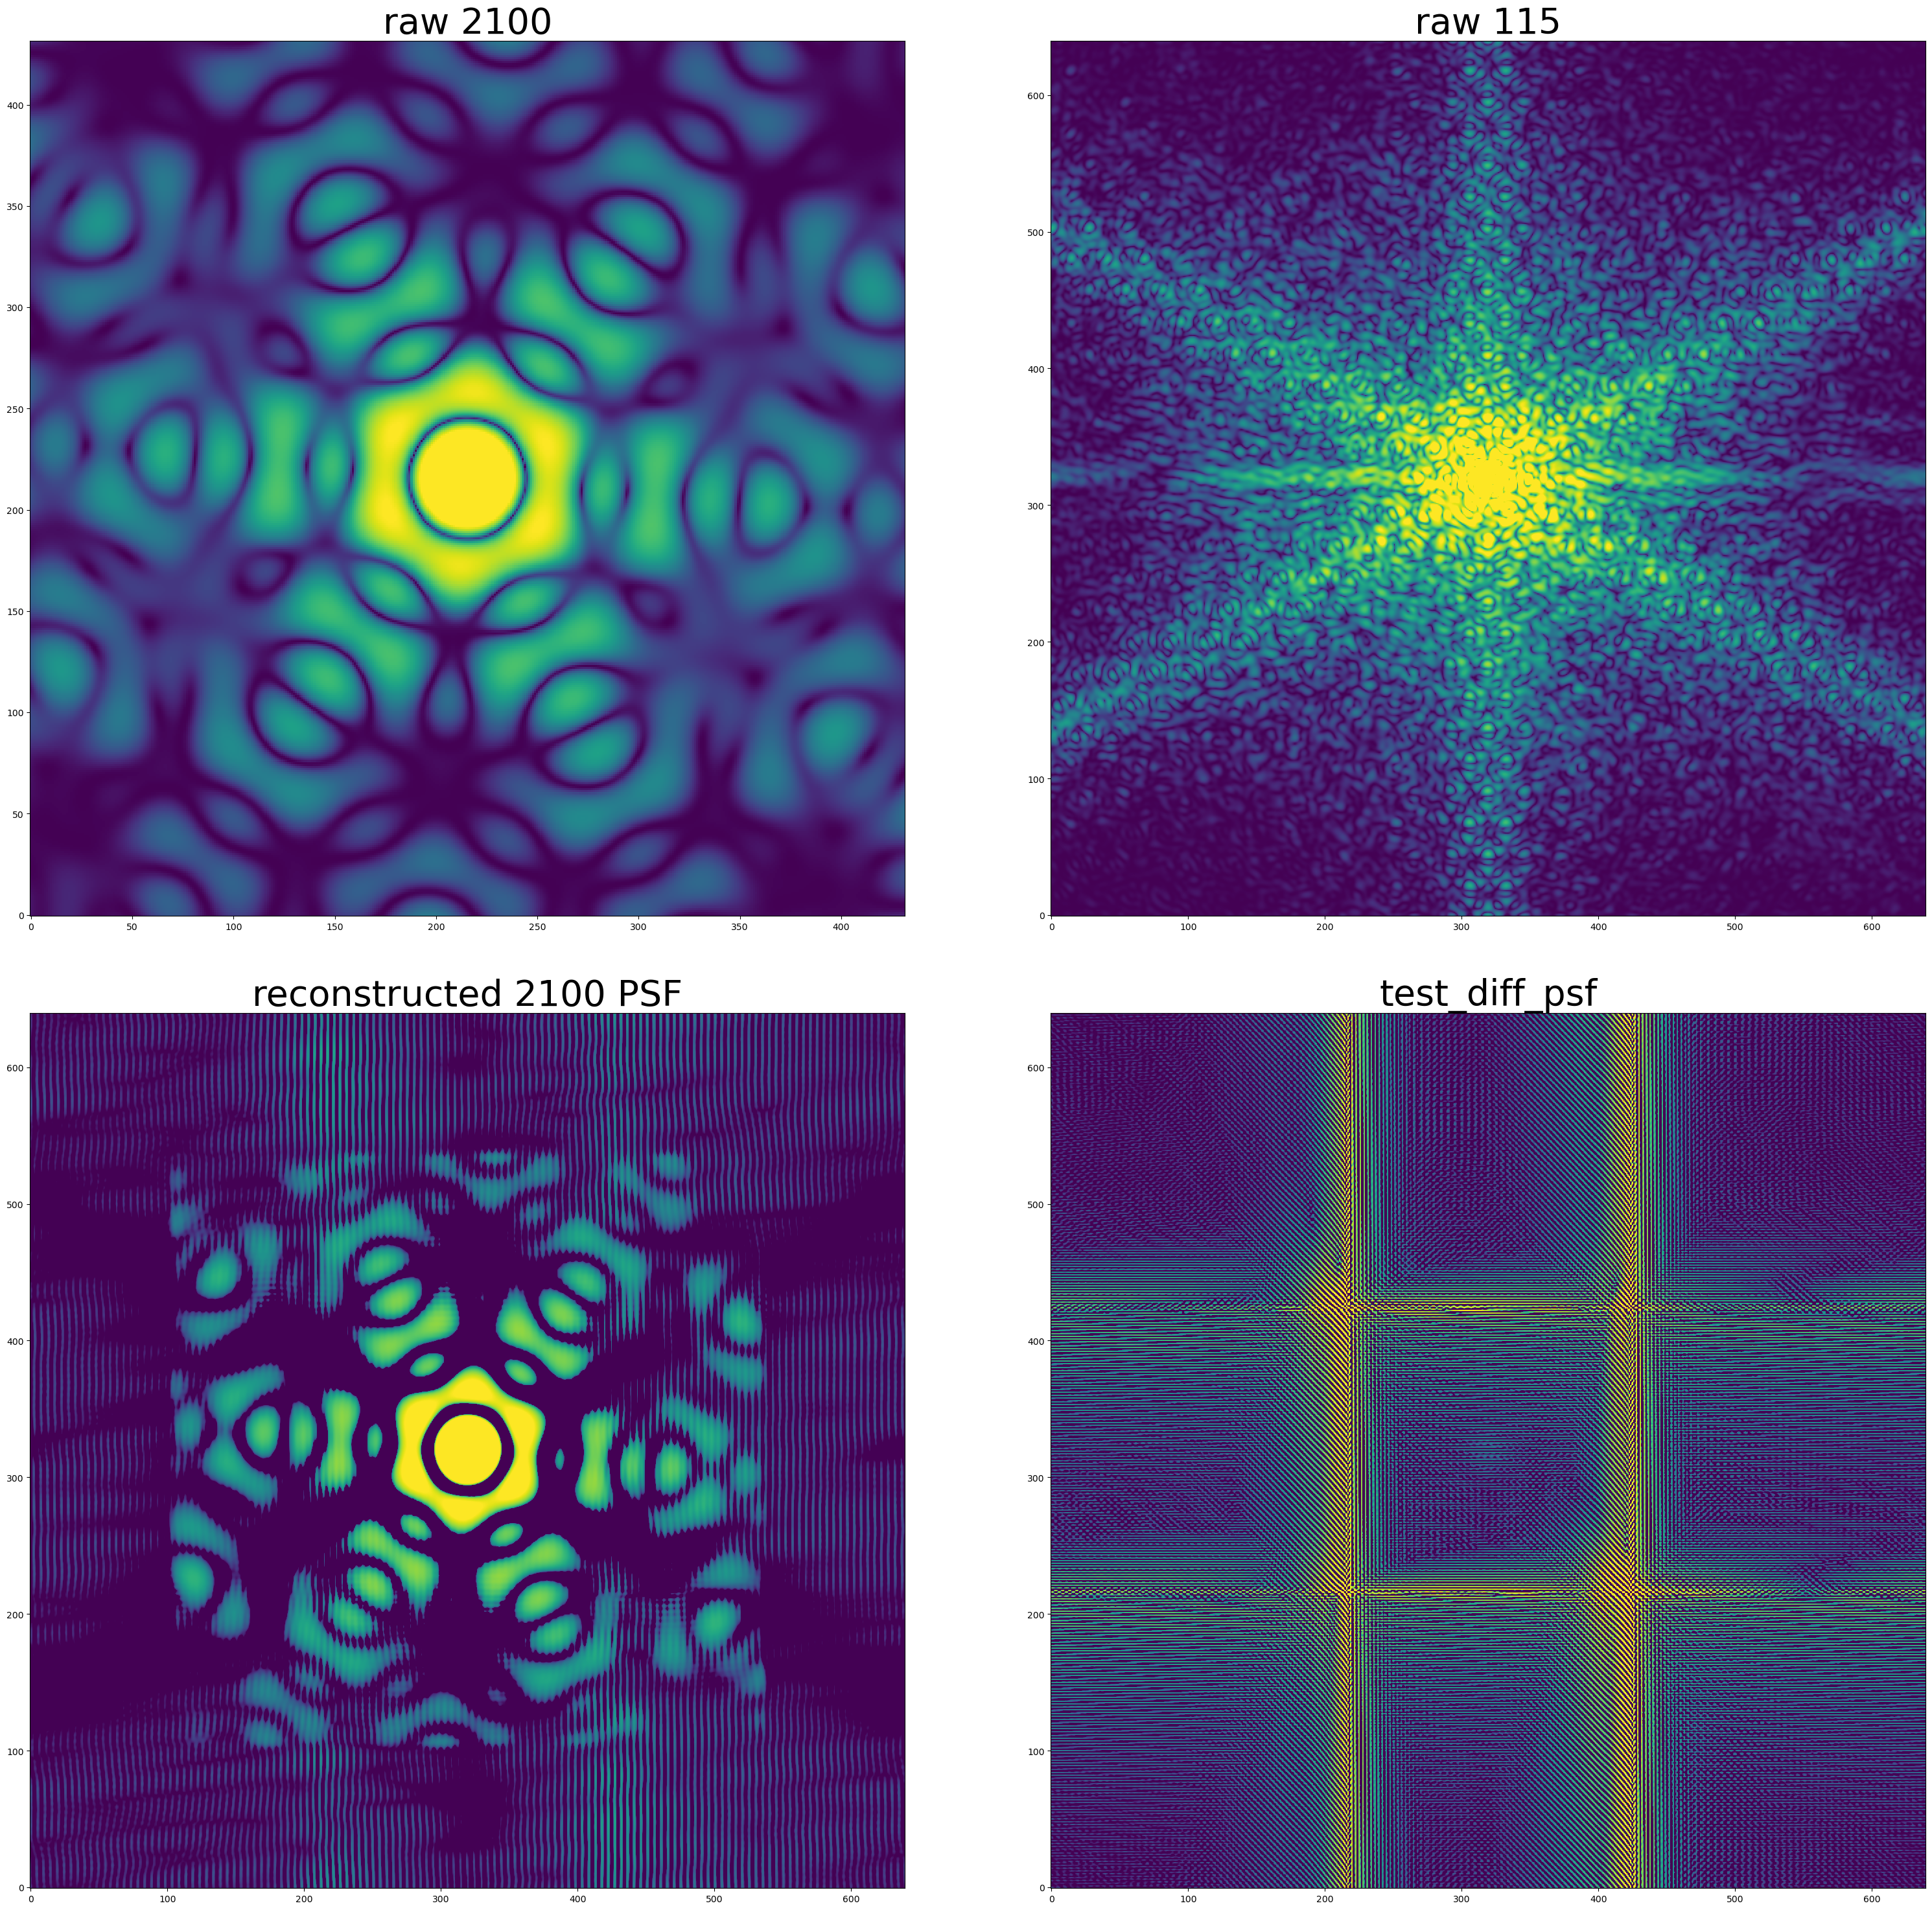

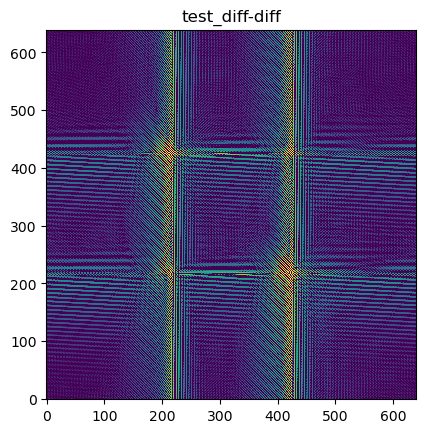

In [7]:
fig = plt.figure(figsize = (45,30))
big_font = 40
ax_2100 = fig.add_axes((0, 0.5, 0.45, 0.45))
inst = webbpsf.MIRI()
inst.filter = 'F2100W'
native_wavelength = 20.795e-6
psf2100 = inst.calc_psf(monochromatic=native_wavelength)
ax_2100.imshow(psf2100[0].data, origin='lower', cmap='viridis',
            norm=ImageNormalize(psf2100[0].data, stretch=LogStretch(), vmin=0, vmax=np.percentile(psf2100[0].data, 99)))
ax_2100.set_title('raw 2100', fontsize = big_font)

ax_115 = fig.add_axes((0.35, 0.5, 0.45, 0.45))
inst = webbpsf.NIRCam()
inst.filter = 'F115W'
native_wavelength = 1.15e-6
psf115 = inst.calc_psf(monochromatic=native_wavelength)
ax_115.imshow(psf115[0].data, origin='lower', cmap='viridis',
            norm=ImageNormalize(psf115[0].data, stretch=LogStretch(), vmin=0, vmax=np.percentile(psf115[0].data, 99)))
ax_115.set_title('raw 115', fontsize = big_font)

diff_psf = compute_diff_kernel(psf115[0].data, psf2100[0].data)
ax_diff = fig.add_axes((0, 0, 0.45, 0.45))

ax_diff.imshow(diff_psf, origin='lower', cmap='viridis',
            norm=ImageNormalize(diff_psf, stretch=LogStretch(), vmin=0, vmax=np.percentile(diff_psf, 99)))
ax_diff.set_title('reconstructed 2100 PSF', fontsize = big_font)

native_psf_matched, target_psf_matched = match_psf_shapes(psf115[0].data, psf2100[0].data)

test_diff_psf = create_matching_kernel(native_psf_matched, target_psf_matched)

ax_test = fig.add_axes((0.35, 0, 0.45, 0.45))

ax_test.imshow(test_diff_psf, origin='lower', cmap='viridis',
            norm=ImageNormalize(test_diff_psf, stretch=LogStretch(), vmin=0, vmax=np.percentile(test_diff_psf, 99)))
ax_test.set_title('test_diff_psf', fontsize = big_font)
plt.show()


#webbpsf.display_psf(psf2100, ext=3, cube_slice=0,
#                    # Note that currently the default plot title isn't very informative for datacube modes
#                    # so we can specify a better title directly here:
#                    title=f'F2100W')
#plt.show()

diff = test_diff_psf - diff_psf
plt.imshow(diff, origin='lower', cmap='viridis', norm=ImageNormalize(diff, stretch=LogStretch(), vmin=0, vmax=np.percentile(diff, 99)))
plt.title('test_diff-diff')
plt.show()



